In [1]:
from load_h5 import Dataset4h5
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import h5py
from scipy.fftpack import fft, fftshift, ifft
from scipy.fftpack import fftfreq
import torch

In [2]:
torch.cuda.is_available()

True

In [3]:
dataset = Dataset4h5('/storage/home/hcoda1/3/bxia34/scratch/LEN128-DIM64-CUB8-4.4-131.341.h5', num_image=192, num_redshift=64, HII_DIM=64, rescale=False, dim=2)

dataset content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
1000 images can be loaded
field.shape = (64, 64, 514)
params keys = [b'ION_Tvir_MIN', b'HII_EFF_FACTOR']
loading 192 images randomly
images loaded: (192, 1, 64, 64)
params loaded: (192, 2)
images rescaled to [0.0, 41.84291076660156]
params rescaled to [4.4, 131.341]


In [4]:
with h5py.File("/storage/home/hcoda1/3/bxia34/scratch/LEN128-DIM64-CUB8-5.6-19.037.h5") as f:
    print(f.keys())
    print(f['redshifts_distances'])
    los = f['redshifts_distances'][:,-dataset.num_redshift:]

<KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
<HDF5 dataset "redshifts_distances": shape (2, 514), type "<f8">


In [5]:
los.shape

(2, 64)

In [6]:
dataloader = DataLoader(dataset, batch_size=192)

In [7]:
len(dataloader)

1

In [8]:
x, c = next(iter(dataloader))

In [9]:
print(x.shape)
print(c.shape)
print(x.min())
print(x.max())

torch.Size([192, 1, 64, 64])
torch.Size([192, 2])
tensor(0.)
tensor(41.8429)


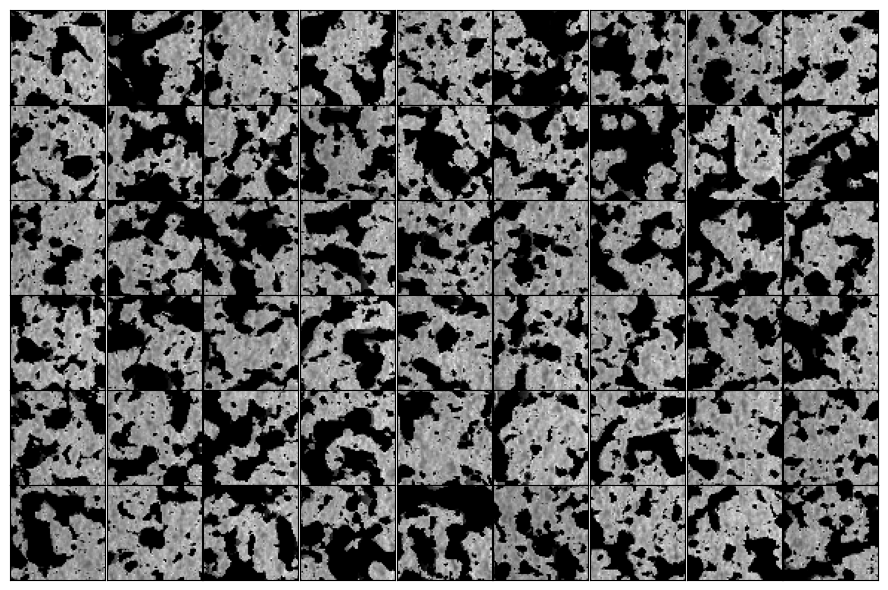

In [10]:
# for i in range(len(x)):
#     plt.imshow(x[i,0,:,0,:])
#     plt.show()
# row = 4
# col = 6
# samples = x[:,:,:,0,:]
def plot(samples, row=6, col=9):
    plt.figure(figsize = (9,6))
    for i in range(54):
        plt.subplot(row,col,i+1)
        plt.imshow(samples[i,0,:,:], cmap='gray')#, vmin=-1, vmax=1)
        plt.xticks([])
        plt.yticks([])
        # plt.show()
    # plt.suptitle('simulations')
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0) 
    plt.show()
    
plot(x[:,:,:,:])

In [11]:
print(x.shape)
Tb = torch.mean(x, axis=2)
print(Tb.shape)
# Tb = torch.mean(Tb, axis=2)
# print(Tb.shape)
# print(Tb.shape)
# print(Tb[:,0,:].shape)
# print(Tb[:10, 0, :].shape)

torch.Size([192, 1, 64, 64])
torch.Size([192, 1, 64])


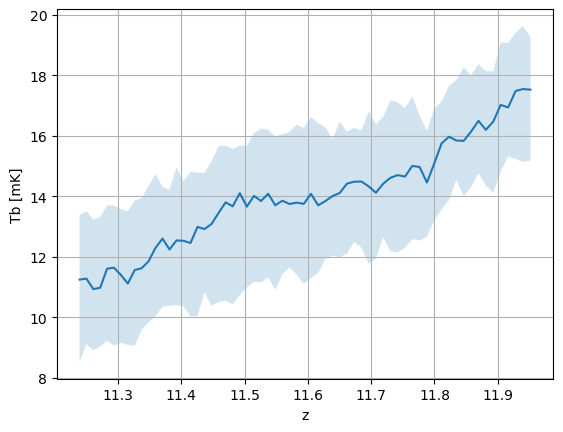

In [12]:
sigma_level = 68.27 

plt.plot(los[0,:], np.median(Tb[:,0,:], axis=0))
plt.fill_between(los[0,:], np.percentile(Tb[:,0,:], 100-sigma_level, axis=0), np.percentile(Tb[:,0,:], sigma_level, axis=0), alpha=0.2)
# for i in range(24):
#     plt.plot(los[0,:], Tb[i,0,:], lw=0.3)
# plt.plot(los[0,:], Tb[1,0,:])
# plt.plot(los[0,:], Tb[2,0,:])
# plt.yscale('log')
plt.grid()
plt.ylabel('Tb [mK]')
plt.xlabel('z')
plt.show()

In [13]:
def calc_ps(field, L):
    ng = field.shape[0]
    ru = np.fft.fftn(field)
    
    ru *= (L/ng)**field.ndim

    if field.ndim == 3:
        ru = ru[0:ng//2+1, 0:ng//2+1, 0:ng//2+1]
    elif field.ndim ==2:
        ru = ru[0:ng//2+1, 0:ng//2+1]

    # ru *= (2/ng)**field.ndim
    ru = np.abs(ru)**2

    kx = np.fft.rfftfreq(ng) * ng / L
    ky = kx.copy()
    kz = kx.copy()

    kmin = 1/L
    kmax = 0.5*ng/L
    
    kbins = np.arange(kmin, kmax, kmin)
    Nk = len(kbins)
    
    if field.ndim == 3:
        k_nd = np.meshgrid(kx, ky, kz, indexing="ij")
    elif field.ndim == 2:
        k_nd = np.meshgrid(kx, ky, indexing="ij")
    
    k = np.sqrt(np.sum(np.array(k_nd)**2,axis=0))

    # hist, edges = np.histogram(k, weights=ru, bins=Nk)
    # Pk = ng * hist / kbins**(field.ndim - 1)
    
    Pk = np.array([np.mean(ru[(k >= kbins[i]) & (k < kbins[i+1])]) for i in range(len(kbins)-1)])
    kbins = (kbins[:-1] + kbins[1:])/2

    if field.ndim == 3:
        Pk *= (kbins**3) / (2*np.pi**2)
    elif field.ndim == 2:
        Pk *= (kbins**2) / (4*np.pi**2)

    return kbins, Pk

In [14]:
# 示例三维密度场
# Nx, Ny, Nz = 64, 64, 512  # 密度场的大小，长方体
# box_size = (128.0, 128.0, 1024.0)  # 盒子大小（单位Mpc/h），对应于 (Lx, Ly, Lz)
# plt.figure(figsize=(6, 4), dpi=100)
# k_vals_all = []
Pk_vals_all = []
for i in range(54):
    density_field = x[i,0,:,:]#np.random.randn(Nx, Ny, Nz)  # 示例密度场，可以替换为实际数据
    if density_field.ndim == 3:
        Nx, Ny, Nz = density_field.shape
        box_size = 128#(128.0, 128.0, 1024.0) #512#
    elif density_field.ndim == 2:
        Nx, Ny = density_field.shape
        box_size = 128#(128.0, 1024.0) #512#

    # 计算物质功率谱
    k_vals, Pk_vals = calc_ps(density_field, box_size)
    # k_vals_all.append(k_vals)
    Pk_vals_all.append(Pk_vals)

    # 计算Delta^2(k)
    # Delta2_vals = k_vals**3 * Pk_vals / (2 * np.pi**2)

    # 计算 k^2 P(k) / (4 * pi^2)
    # k2Pk_vals = k_vals**2 * Pk_vals / (4 * np.pi**2)

    # 绘制功率谱
    # plt.subplot(1, 1, 1)
    # plt.plot(k_vals, Pk_vals, '--', lw=0.5)#, 'b-')
    # plt.plot(k_vals, k2Pk_vals, ':', lw=0.1)#, 'b-')

# plt.xlabel('k [Mpc$^{-1}$]')
# plt.ylabel(r'P(k) [Mpc$^3$]')
# plt.title('Simulations Power Spectrum')
# plt.grid(True)

# k_vals_all = np.array(k_vals_all)
# print(k_vals_all.shape)
Pk_vals_all = np.array(Pk_vals_all)
# print(Pk_vals_all.shape)

# sigma_level = 68.27 
# plt.plot(k_vals, np.median(Pk_vals_all, axis=0), 'k-')
# plt.fill_between(k_vals, np.percentile(Pk_vals_all, 100-sigma_level, axis=0), np.percentile(Pk_vals_all, sigma_level, axis=0), alpha=0.5, color='C0')

# plt.plot(k_vals, Pk_vals_all.mean(axis=0), 'k-', lw=1, label='mean')
# k_vals_all_sim = k_vals_all
Pk_vals_all_sim = Pk_vals_all
# plt.xscale('log')
# plt.yscale('log')

# plt.tight_layout()
# plt.legend()
# plt.show()

# # plt.subplot(2, 1, 2)
# plt.plot(k_vals, Delta2_vals, 'r-', label='$\\Delta^2(k) = \\frac{k^3 P(k)}{2\\pi^2}$')
# plt.plot(k_vals, k2Pk_vals, 'g--', label='$\\frac{k^2 P(k)}{4\\pi^2}$')
# plt.xlabel('k [h/Mpc]')
# plt.ylabel('Power')
# plt.title('Normalized Power Spectrum')
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(xmin=1e-2)
# plt.legend()
# plt.grid(True)

In [15]:
ll -lth outputs

total 879M
-rw-r--r-- 1 bxia34 3.1M Jun  5 00:11 0604-2353.npy
-rw-r--r-- 1 bxia34 848M Jun  4 23:53 model_state.pth
drwxr-xr-x 9 bxia34 4.0K Jun  4 23:05 logs/
-rw-r--r-- 1 bxia34 3.1M Jun  4 20:41 test_0_0.npy
-rw-r--r-- 1 bxia34 3.1M Jun  4 19:45 test_8_038.npy
-rw-r--r-- 1 bxia34 3.1M Jun  4 18:00 test_2_506.npy
-rw-r--r-- 1 bxia34 3.1M Jun  4 17:01 0604-1643.npy
-rw-r--r-- 1 bxia34 3.1M May 29 15:08 0529-1450.npy
-rw-r--r-- 1 bxia34 385K May 29 14:41 0529-1439.npy
-rw-r--r-- 1 bxia34 385K May 29 01:51 0529-0149.npy
-rw-r--r-- 1 bxia34 385K May 29 01:12 0529-0110.npy
-rw-r--r-- 1 bxia34 385K May 28 23:38 0528-2336.npy
-rw-r--r-- 1 bxia34 385K May 28 23:03 0528-2301.npy
-rw-r--r-- 1 bxia34 385K May 28 17:34 0528-1732.npy
-rw-r--r-- 1 bxia34 385K May 28 16:26 0528-1624.npy
-rw-r--r-- 1 bxia34 385K May 28 14:35 0528-1433.npy
-rw-r--r-- 1 bxia34 385K May 28 14:17 0528-1416.npy
-rw-r--r-- 1 bxia34 385K May 27 21:55 0527-2152.npy
-rw-r--r-- 1 bxia34 3.1M May 27 21:34 0527-2117.npy
-rw-r-

In [16]:
# x_sample = np.load("outputs/0527-1951.npy")
x_sample = np.load("outputs/0604-2353.npy")
print(x_sample.shape)
x_sample = torch.from_numpy(x_sample)
print(x_sample.shape)
print(x_sample.max())
print(x_sample.min())
# plt.imshow(x_sample[0,0,:,:])
# plt.show()

(192, 1, 64, 64)
torch.Size([192, 1, 64, 64])
tensor(-0.0011)
tensor(-1.0541)


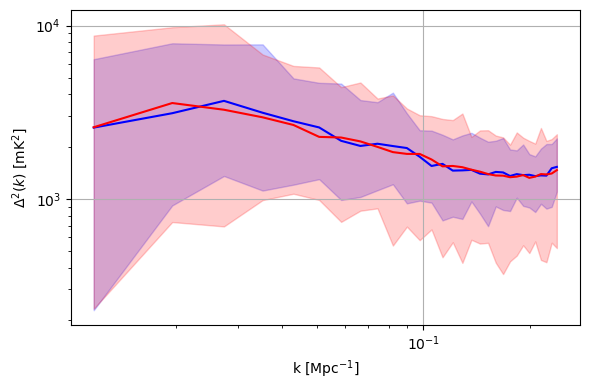

In [17]:
# 示例三维密度场
# Nx, Ny, Nz = 64, 64, 512  # 密度场的大小，长方体
# box_size = (128.0, 128.0, 1024.0)  # 盒子大小（单位Mpc/h），对应于 (Lx, Ly, Lz)
plt.figure(figsize=(6, 4), dpi=100)
# k_vals_all = []
Pk_vals_all = []
for i in range(192):
    
    density_field = (x_sample[i,0,:,:]+1)/2 * 80#np.random.randn(Nx, Ny, Nz)  # 示例密度场，可以替换为实际数据
    if density_field.dim() == 3:
        Nx, Ny, Nz = density_field.shape
        box_size = 128.0
    elif density_field.dim() == 2:
        Nx, Ny = density_field.shape
        box_size = 128.0

    # 计算物质功率谱
    k_vals, Pk_vals = calc_ps(density_field, box_size)
    # k_vals_all.append(k_vals)
    Pk_vals_all.append(Pk_vals)

    # 计算Delta^2(k)
    # Delta2_vals = k_vals**3 * Pk_vals / (2 * np.pi**2)

    # 计算 k^2 P(k) / (4 * pi^2)
    # k2Pk_vals = k_vals**2 * Pk_vals / (4 * np.pi**2)

    # 绘制功率谱
    # plt.subplot(1, 1, 1)
    # plt.plot(k_vals, Pk_vals, '--', lw=0.5)#, 'b-')

plt.xlabel('k [Mpc$^{-1}$]')
plt.ylabel(r'$\Delta^2(k)$ [mK$^2$]')
# plt.title('Power Spectrum for random $\log T_{vir}$, $\zeta$')
# plt.title('Power Spectrum for $\log T_{vir}$, $\zeta$ =' + f" {c[0].numpy()}")
plt.grid(True)

# k_vals_all = np.array(k_vals_all)
# print(k_vals_all.shape)
Pk_vals_all_diffusion = np.array(Pk_vals_all)
# print(Pk_vals_all.shape)
    # plt.subplot(2, 1, 2)
    # plt.loglog(k_vals, Delta2_vals, 'r-', label='$\\Delta^2(k) = \\frac{k^3 P(k)}{2\\pi^2}$')
    # plt.loglog(k_vals, k2Pk_vals, 'g--', label='$\\frac{k^2 P(k)}{4\\pi^2}$')
    # plt.xlabel('k [h/Mpc]')
    # plt.ylabel('Power')
    # plt.title('Normalized Power Spectrum')
    # # plt.legend()
    # plt.grid(True)
sigma_level = 0

plt.plot(k_vals, np.median(Pk_vals_all_sim, axis=0), 'b-', label='sim')
# plt.plot(k_vals, k_vals**2/(4*np.pi**2)*np.median(Pk_vals_all_sim, axis=0), 'b--', lw=1)
plt.fill_between(k_vals, np.percentile(Pk_vals_all_sim, 100-sigma_level, axis=0), np.percentile(Pk_vals_all_sim, sigma_level, axis=0), alpha=0.2, color='b')


plt.plot(k_vals, np.median(Pk_vals_all_diffusion, axis=0), 'r-', label='diffusion')
# plt.plot(k_vals, k_vals**2/(4*np.pi**2)*np.median(Pk_vals_all_diffusion, axis=0), 'r--', lw=1)
plt.fill_between(k_vals, np.percentile(Pk_vals_all_diffusion, 100-sigma_level, axis=0), np.percentile(Pk_vals_all_diffusion, sigma_level, axis=0), alpha=0.2, color='r')
# plt.plot(k_vals_all.mean(axis=0), Pk_vals_all.mean(axis=0), 'r--', lw=4, label="samples' mean")
# plt.plot(k_vals_all_sim.mean(axis=0), Pk_vals_all_sim.mean(axis=0), 'k-', lw=1, label="simulations' mean")

plt.xscale('log')
plt.yscale('log')
# plt.xlim(xmin=0.01)
# plt.legend()
plt.tight_layout()
plt.show()

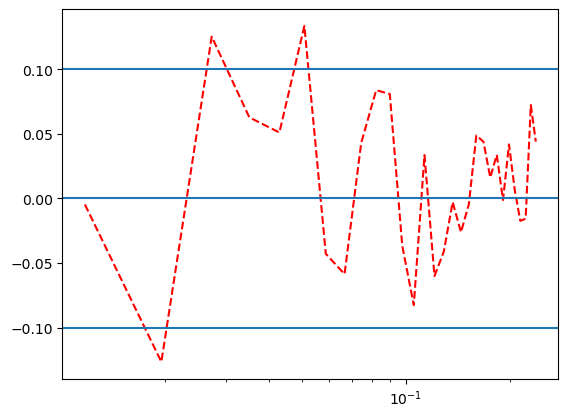

In [18]:
y1 = np.median(Pk_vals_all_sim, axis=0)
y2 = np.median(Pk_vals_all_diffusion, axis=0)
# plt.plot(k_vals, np.abs(y1-y2)/y2, 'b-', label='diffusion')
plt.plot(k_vals, (y1-y2)/y2, 'r--', label='diffusion')
plt.xscale('log')
plt.hlines(0,0.01,0.3)
plt.hlines(0.1,0.01,0.3)
plt.hlines(-0.1,0.01,0.3)
# plt.plot(k_vals, , 'r-', label='diffusion')

torch.Size([192, 1, 64, 64])


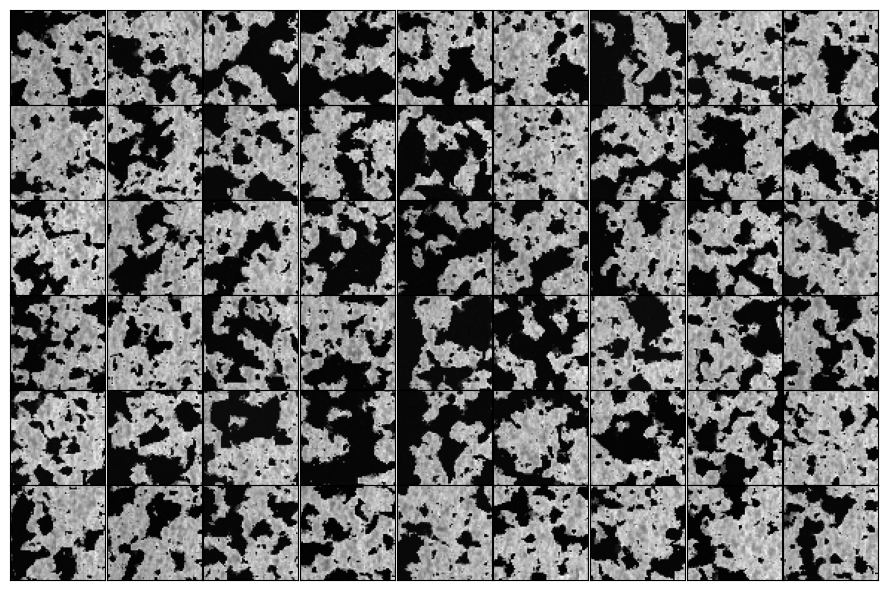

In [19]:
# for i in range(24):
#     plt.imshow(x_sample[i,0])
#     plt.show()
print(x_sample.shape)
plot(x_sample)

x_sample.shape = torch.Size([192, 1, 64, 64])
x.shape = torch.Size([192, 1, 64, 64])
x_sample tensor(-0.0011) tensor(-1.0541)
x_sample tensor(-0.0011) tensor(-1.0541)
Tb tensor(24.6047) tensor(0.)


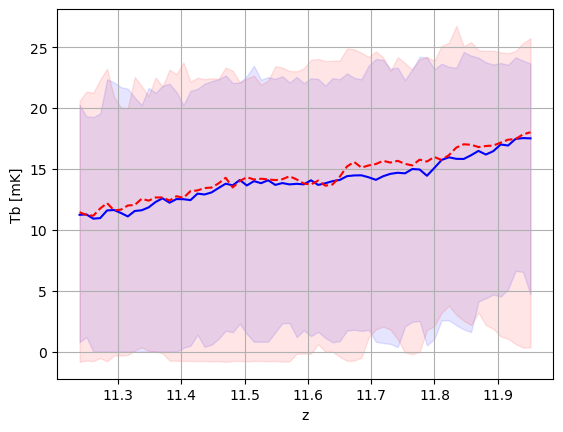

In [20]:
print("x_sample.shape =", x_sample.shape)
print("x.shape =", x.shape)
print("x_sample", x_sample.max(), x_sample.min())
x_sample_truc = x_sample#torch.where(x_sample < -1, -1, x_sample)
print("x_sample", x_sample_truc.max(), x_sample_truc.min())
Tb_sample = (x_sample_truc.mean(axis=2) + 1) / 2 *80
print("Tb", Tb.max(), Tb.min())
plt.plot(los[0,:], np.median(Tb[:,0,:], axis=0),'b-', label="simulations' average")
plt.plot(los[0,:], np.median(Tb_sample[:,0,:], axis=0),'r--', label="samples' average")

# plt.plot(los[0,:], Tb[:,0,:].mean(axis=0))
plt.fill_between(los[0,:], np.percentile(Tb[:,0,:], 100-sigma_level, axis=0), np.percentile(Tb[:,0,:], sigma_level, axis=0), alpha=0.1, color='b')

plt.fill_between(los[0,:], np.percentile(Tb_sample[:,0,:], 100-sigma_level, axis=0), np.percentile(Tb_sample[:,0,:], sigma_level, axis=0), alpha=0.1, color='r')
# for i in range(24):
#     plt.plot(los[0,:], Tb_sample[i,0,:], lw=0.3)
# plt.plot(los[0,:], Tb[1,0,:])
# plt.plot(los[0,:], Tb[2,0,:])
# plt.yscale('log')
# plt.title('Global signal for $\log T_{vir}$, $\zeta$ =' + f" {c[0].numpy()}")
# plt.title('Global signal for random $\log T_{vir}$, $\zeta$')
plt.ylabel('Tb [mK]')
plt.xlabel('z')
plt.grid()
# plt.legend()
plt.show()

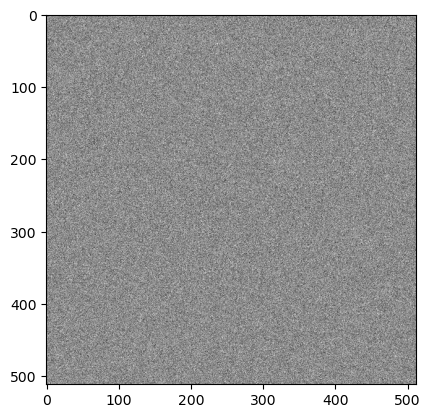

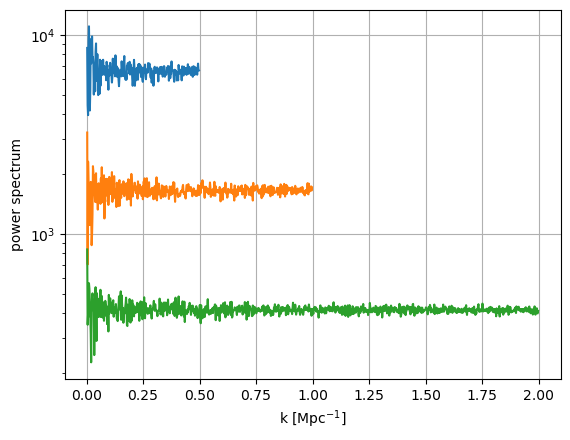

In [21]:
image = np.random.normal(0,1,(512,512))
image_1 = np.random.normal(0,1,(1024,1024))
image_2 = np.random.normal(0,1,(2048,2048))
# x = np.arange(64)
# image_x, image_y, image_z = np.meshgrid(np.sin(x), np.cos(2*x), np.sin(3*x)*np.cos(5*x))
# image = image_x * image_y * image_z #+ np.random.normal(0,0.1,image_x.shape)

k, ps = calc_ps(torch.tensor(image), 512)
k_1, ps_1 = calc_ps(torch.tensor(image_1), 512)
k_2, ps_2 = calc_ps(torch.tensor(image_2), 512)
# print("k.max() =", k.max())
plt.imshow(image, cmap='gray')
plt.show()

plt.plot(k, ps/k**2)
plt.plot(k_1, ps_1/k_1**2)
plt.plot(k_2, ps_2/k_2**2)
plt.xlabel('k [Mpc$^{-1}$]')
plt.ylabel('power spectrum')
# plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.show()

In [22]:
# import numpy as np
# import matplotlib.pyplot as plt

# # 生成一个标准正态分布的白噪声图像
# N = 1024  # 图像尺寸
# noise_image = np.random.normal(loc=0.0, scale=1.0, size=(N, N))
# # noise_image = x_sample[0,0]

# # 计算图像的二维傅里叶变换
# ft_image = np.fft.fft2(noise_image)
# ft_image_shifted = np.fft.fftshift(ft_image)  # 将低频移到中心

# # 计算功率谱
# power_spectrum = np.abs(ft_image_shifted)**2 / (N * N)

# # 计算环形平均功率谱
# def azimuthalAverage(image, center=None):
#     y, x = np.indices(image.shape)
#     if not center:
#         center = np.array([(x.max() - x.min()) / 2.0, (y.max() - y.min()) / 2.0])
#     r = np.hypot(x - center[0], y - center[1])
#     r = r.astype(np.int)
#     tbin = np.bincount(r.ravel(), image.ravel())
#     nr = np.bincount(r.ravel())
#     radialprofile = tbin / nr
#     return radialprofile

# # 计算环形平均功率谱
# radial_profile = azimuthalAverage(power_spectrum)

# # 绘制功率谱
# plt.figure()
# k = np.arange(len(radial_profile))
# # plt.loglog(radial_profile)
# plt.loglog(k, radial_profile*k**2)
# plt.xlabel('Frequency (log scale)')
# plt.ylabel('Power Spectrum (log scale)')
# plt.title('Power Spectrum of White Noise Image')
# plt.hlines(1, 0,200)
# plt.show()

# # 打印平均功率谱值
# print(f"Average Power Spectrum Value: {np.mean(radial_profile)}")
